# Сервис аренды самокатов GoFast.

Вы аналитик популярного сервиса аренды самокатов *GoFast*. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса *GoFast* пользуются мобильным приложением.   
  
Сервисом можно пользоваться:  
  
без подписки: 
  
абонентская плата отсутствует;  
стоимость одной минуты поездки — 8 рублей;    
стоимость старта (начала поездки) — 50 рублей;  
  
с подпиской *Ultra*:
  
абонентская плата — 199 рублей в месяц;  
стоимость одной минуты поездки — 6 рублей;  
стоимость старта — бесплатно.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from math import factorial
from math import sqrt

## Шаг 1. **Загрузка данных**

In [2]:
# открываем файл из директории или по ссылке
try:
    users = pd.read_csv('/datasets/users_go.csv')
    rides = pd.read_csv('/datasets/rides_go.csv')
    subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
    rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
    subscriptions = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

### Знакомство с данными

Выводим первые строки каждого дата фрейма для первичного просмотра.  
Посмотрим общую информацию.

In [3]:
users.head() # Пользователи

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


**Описание данных:**  
**user_id** - уникальный идентификатор пользователя  
**name** - имя пользователя  
**age** - возраст  
**city**- город  
**subscription_type** - тип подписки (free, ultra)

In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Как и следует из названия таблица содержит общую информацию о пользователях. Имеет 5 колонок (две типа *int64* и три *object*) и  1565 строк.

In [5]:
rides.head() # Поездки

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


**Описание данных:**  
**user_id** - уникальный идентификатор пользователя  
**distance** - расстояние, которое пользователь проехал в текущей сессии (в метрах)  
**duration** - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»  
**date** - дата совершения поездки

In [6]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


В этой таблице собраны общие данные о поездках. Таблица имеет 4 колонки ( одна типа *int64*, две *float64* и одна *object*) и 18068 строк. В колонке *date* нужно изменить тип данных с *object* на *datetime64*.

In [7]:
subscriptions.head() # Подписки

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Описание данных:**  
**subscription_type** - тип подписки  
**minute_price** - стоимость одной минуты поездки по данной подписке  
**start_ride_price** - стоимость начала поездки  
**subscription_fee** - стоимость ежемесячного платежа

In [8]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


В этой таблице собранны данные о типе подписки пользователей в мобильном приложении. Имеет 4 колонки (одна типа *object* и три *int64*) и содержит 2 строки.

## Шаг 2. **Предобработка данных**

### Типы данных

Проверим типы данных

In [9]:
users.dtypes

user_id               int64
name                 object
age                   int64
city                 object
subscription_type    object
dtype: object

In [10]:
rides.dtypes

user_id       int64
distance    float64
duration    float64
date         object
dtype: object

In [11]:
subscriptions.dtypes

subscription_type    object
minute_price          int64
start_ride_price      int64
subscription_fee      int64
dtype: object

В датасете Поездки нужно обработать столбец *data* - изменить тип данных с  *object* на *datetime*.

In [12]:
rides['date'] = pd.to_datetime(rides['date'], format = 'ISO8601')

In [13]:
# Проверяем
rides.dtypes

user_id              int64
distance           float64
duration           float64
date        datetime64[ns]
dtype: object

In [14]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


### Работа со столбцами

Создаём новый столбец с номером месяца на основе столбца *date*.

In [15]:
rides['month'] = rides['date'].dt.month

In [16]:
# Проверяем
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [17]:
# Посмотрим начальную дату таблицы
rides['date'].min()

Timestamp('2021-01-01 00:00:00')

In [18]:
# Посмотрим конечную дату таблицы
rides['date'].max()

Timestamp('2021-12-30 00:00:00')

Данные прадставленные в этом исследовании за период с 1 января 2021 года по 30 декабря 2021 года.

### Обработка дубликатов и пропусков

In [19]:
# проверим дубликаты и выведем их сумму
users.duplicated().sum()

31

In [20]:
# проверим дубликаты и выведем их сумму
rides.duplicated().sum()

0

In [21]:
# проверим дубликаты и выведем их сумму
subscriptions.duplicated().sum()

0

In [22]:
# Удаляем дубликаты
users = users.drop_duplicates()

In [23]:
# проверим
users.duplicated().sum()

0

In [24]:
# Проверим пропуски
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [25]:
# Проверим пропуски
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [26]:
# Проверим пропуски
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

На этапе предобработки данных были проверенны и преобразованны типы данных, найдены и удаленны дубликаты, проверенны пропуски и добавлен столбец *month* в таблице *rides*. 

## Шаг 3. **Исследовательский анализ данных**

### Города

Проверим частоту встречаемости городов

In [27]:
users['city'].value_counts().sort_values()

city
Москва            168
Тюмень            180
Омск              183
Сочи              189
Краснодар         193
Ростов-на-Дону    198
Екатеринбург      204
Пятигорск         219
Name: count, dtype: int64

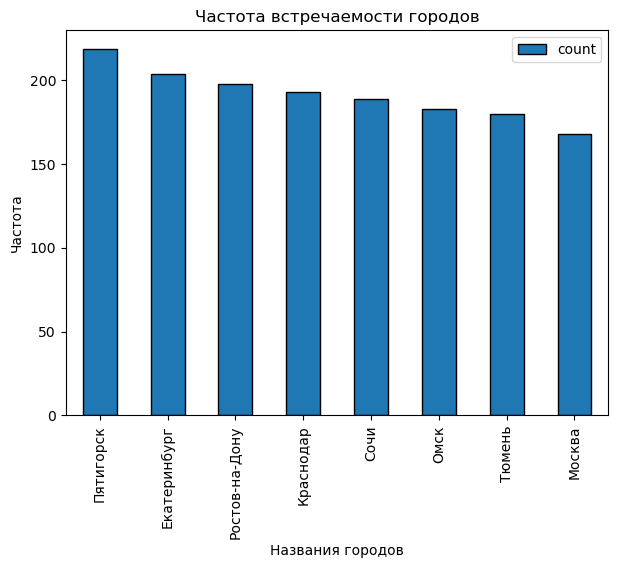

In [28]:
# Отобразим это на графике
users['city'].value_counts().plot.bar(figsize=(7, 5), ec='black', legend=True)

plt.title('Частота встречаемости городов')
plt.xlabel('Названия городов')
plt.ylabel('Частота')
plt.show()

Из графика следует что чаще всего пользователи пользуются самокатами компании *GoFast* в Пятигорске и Екатеринбурге, соответсевенно меньше всего в Москве и Тюмени.

### Пользователи

Проверим соотношение пользователей с подпиской и без подписки.

In [29]:
users['subscription_type'].value_counts().sort_values()

subscription_type
ultra    699
free     835
Name: count, dtype: int64

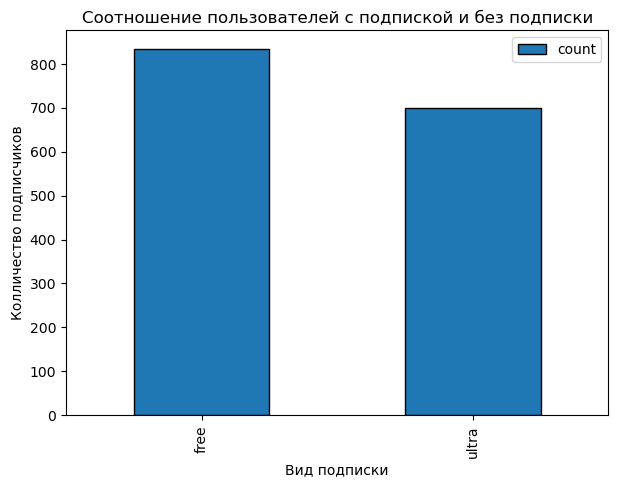

In [30]:
# Отобразим это на графике
users['subscription_type'].value_counts().plot.bar(figsize=(7, 5), ec='black', legend=True)

plt.title('Соотношение пользователей с подпиской и без подписки')
plt.xlabel('Вид подписки')
plt.ylabel('Колличество подписчиков')
plt.show()

Из графика следует что пользователей с бесплатной подпиской больше чем с платной.    

Посмотрим возраст пользователей

In [31]:
users['age'].value_counts().sort_values()

age
43      1
39      1
37      2
38      3
12      4
36      6
13      8
14      9
15     13
35     15
34     19
16     19
17     26
33     39
32     41
18     46
19     47
31     48
29     68
30     68
20     71
21     93
28    112
27    119
22    119
23    129
26    131
24    132
25    145
Name: count, dtype: int64

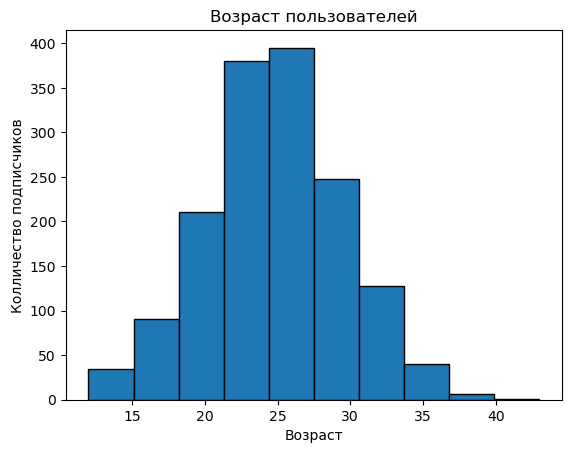

In [32]:
# Отобразим это на графике
users['age'].sort_values().plot(y = 'age', kind = 'hist', bins = 10, range=(12,43), ec='black')

plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Колличество подписчиков')
plt.show()

Из графика следует что основная масса пользователей имеет возраст от 17 до 34 лет.   
Меньше всего сервисом пользуются пользователи в возрасте от 37, 43 лет

### Расстояние

Посмотрим общие данные по расстоянию, которое пользователь преодолел за одну поездку в метрах.

In [33]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Посмотрим график

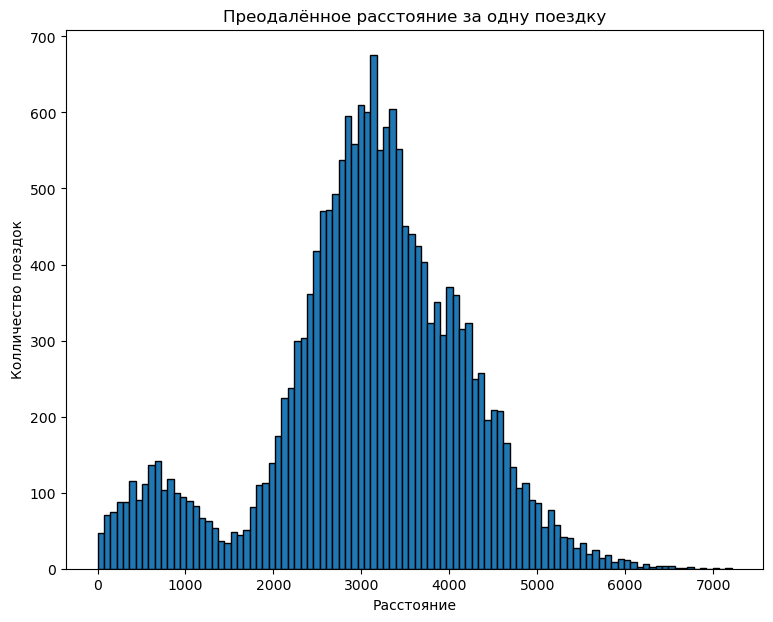

In [34]:
rides['distance'].sort_values().plot(y = 'distance', kind = 'hist', bins = 100, ec='black', figsize=(9, 7))

plt.title('Преодалённое расстояние за одну поездку')
plt.xlabel('Расстояние')
plt.ylabel('Колличество поездок')
plt.show()

- Из графика видно что основная масса поездок совершена на расстояние от 2200 метров до 4700 метров.

- Унас есть ещё одно пиковое значение с расстоянием от 0,8 метра до 1500 метров.

In [35]:
# Сделаем срез по этому пику
rides_distance = rides.loc[rides['distance'] <= 1500]
rides_distance

,user_id,distance,duration,date,month
2,1,754.159807,6.232113,2021-04-20,4
9,1,748.690645,15.041884,2021-11-22,11
20,2,923.007439,6.914760,2021-08-03,8
47,4,724.559572,11.811399,2021-11-14,11
91,9,979.657684,17.521497,2021-03-08,3
...,...,...,...,...,...
18031,1532,303.787850,7.792490,2021-05-21,5
18037,1532,662.468186,9.528773,2021-11-18,11
18043,1533,310.488247,10.642389,2021-02-21,2
18049,1533,1034.998188,6.299996,2021-06-23,6


In [36]:
# Посмотрим колличество поездок по месяцам
rides_distance['month'].value_counts().sort_values()

month
5     128
4     137
7     139
6     142
2     143
9     147
10    150
11    157
12    158
1     159
8     167
3     169
Name: count, dtype: int64

In [37]:
# Посмотрим затраченное время по этим поездкам 
rides_distance['duration'].describe()

count    1796.000000
mean       10.170259
std         3.956201
min         2.035632
25%         6.921965
50%        10.094883
75%        13.456112
max        20.457599
Name: duration, dtype: float64

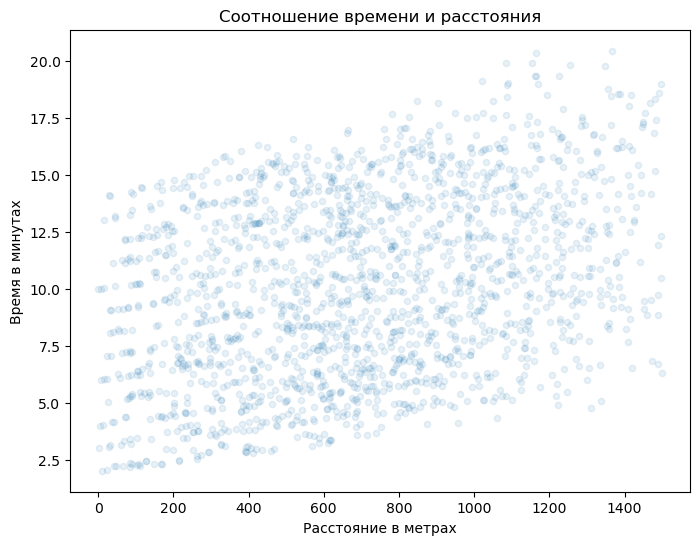

In [38]:
# используем тип графика scatter
rides_distance.plot(x='distance', y ='duration', kind ='scatter', figsize=(8, 6), legend=True, alpha = 0.1)

plt.title('Соотношение времени и расстояния')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Время в минутах')
plt.show()

- Время затраченное на эти поездки составляет от 2 минут до 20 минут.  
Пользователи использовали самокаты практически круглый год, возможно это связанно с определённым городом. Нужно проверить в дальнейшем по сводной таблице.

### Время

Посмотрим общие данные продолжительности поездок в минутах.

In [39]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

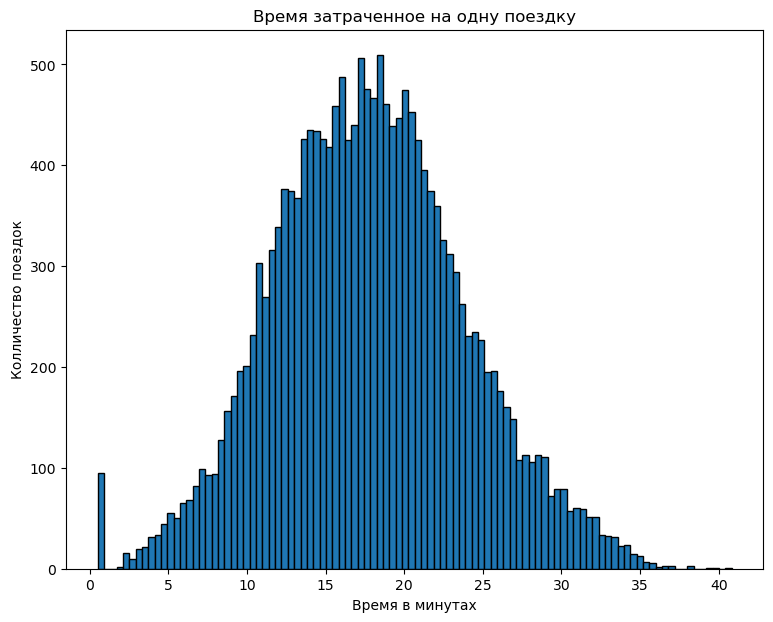

In [40]:
rides['duration'].sort_values().plot(y = 'duration', kind = 'hist', bins = 100, ec='black', figsize=(9, 7))

plt.title('Время затраченное на одну поездку')
plt.xlabel('Время в минутах')
plt.ylabel('Колличество поездок')
plt.show()

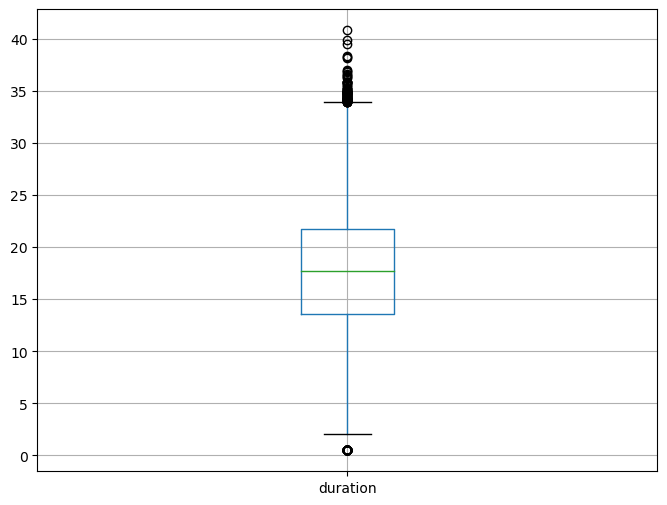

In [41]:
# Построим диаграмму размаха
rides.boxplot(column='duration', figsize=(8, 6))
plt.show()

На графиках виден аномальный выброс со временем от 0 минут до 1 минуты.  
Сделаем срез и посмотрим таблицу.

In [42]:
rides.query('duration < 1')

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


95 поездок продолжительностью 0,5 минуты на расстояние более 4000 метров - явная ошибка в данных о длительности поездки.
У нас нет данных о том откуда взялись такие записи, системный сбой или проведение акций для подписчиков, так как плата взымается за время пользования самокатом то считаю что это не повлияет на конечный результат исследования.  
Удаляем эти выбросы.

In [43]:
# Удаляем выбросы 
rides = rides.query('1 < duration', engine= 'python')

## Шаг 4. **Объединение данных**

### Объединение таблиц

Сразу объединить все таблицы не получится, так как нет одного общего столбца во всех трёх таблицах.  
будем объединять по очереди.  
Сначала объединим "Пользователей" и "Поездки"

In [44]:
users_rides = users.merge(rides, on='user_id', how='left')
users_rides.head(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11


Теперь присоединим "Подписки"

In [45]:
users_rides_subscriptions = users_rides.merge(subscriptions, on='subscription_type', how='left')
users_rides_subscriptions.tail(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
17963,1534,Альберт,25,Краснодар,free,195.447469,6.469074,2021-06-11,6,8,50,0
17964,1534,Альберт,25,Краснодар,free,3214.021065,18.343604,2021-06-18,6,8,50,0
17965,1534,Альберт,25,Краснодар,free,3644.708038,20.289416,2021-08-08,8,8,50,0
17966,1534,Альберт,25,Краснодар,free,3977.744996,26.916544,2021-08-20,8,8,50,0
17967,1534,Альберт,25,Краснодар,free,4928.173852,22.560373,2021-09-13,9,8,50,0
17968,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
17969,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
17970,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
17971,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0
17972,1534,Альберт,25,Краснодар,free,2371.711192,15.893917,2021-12-29,12,8,50,0


Сравним длинну объединённой таблицы с длинной исходных таблиц.

In [46]:
len(users)

1534

In [47]:
len(rides)

17973

In [48]:
len(subscriptions)

2

In [49]:
len(users_rides_subscriptions)

17973

Длинна совпадает с длинной самого большой таблицы, значит все данные на месте.

### Создание таблиц

Создаём два датафрейма из датафрейма, созданного на предыдущем этапе.

первый c данными о пользователях без подписки

In [50]:
users_rides_subscriptions_free = users_rides_subscriptions.loc[users_rides_subscriptions['subscription_type'] == 'free']

In [51]:
users_rides_subscriptions_free

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
17968,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
17969,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
17970,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
17971,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


Второй c данными о пользователях с подпиской

In [52]:
users_rides_subscriptions_ultra = users_rides_subscriptions.loc[users_rides_subscriptions['subscription_type'] == 'ultra']

In [53]:
users_rides_subscriptions_ultra

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10,6,0,199


### Визуализация данных

Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

In [54]:
# посмотрим колличество поездок совершённых с подпиской 
len(users_rides_subscriptions_ultra)

6500

In [55]:
# теперь без подписки
len(users_rides_subscriptions_free)

11473

In [56]:
# Посмотрим общую информацию времени использования для пользователей с подпиской
users_rides_subscriptions_ultra['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

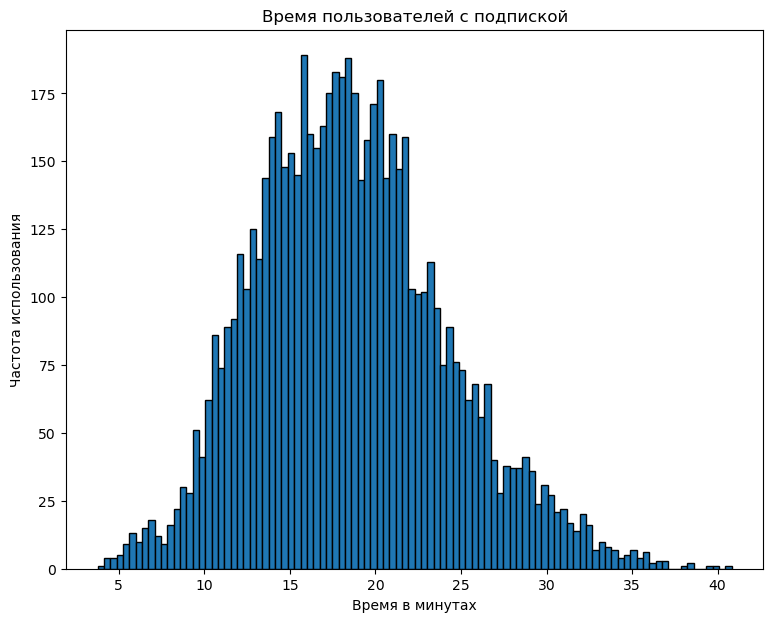

In [57]:
# Построим график времени использования для пользователей с подпиской
users_rides_subscriptions_ultra['duration'].sort_values().plot(y = 'duration', kind = 'hist', bins = 100, ec='black', figsize=(9, 7))

plt.title('Время пользователей с подпиской')
plt.xlabel('Время в минутах')
plt.ylabel('Частота использования')
plt.show()

In [58]:
# Посмотрим общую информацию о времени использования для пользователей без подписки
users_rides_subscriptions_free['duration'].describe()

count    11473.000000
mean        17.530771
std          6.162609
min          2.035632
25%         13.085688
50%         17.383807
75%         21.638038
max         34.948498
Name: duration, dtype: float64

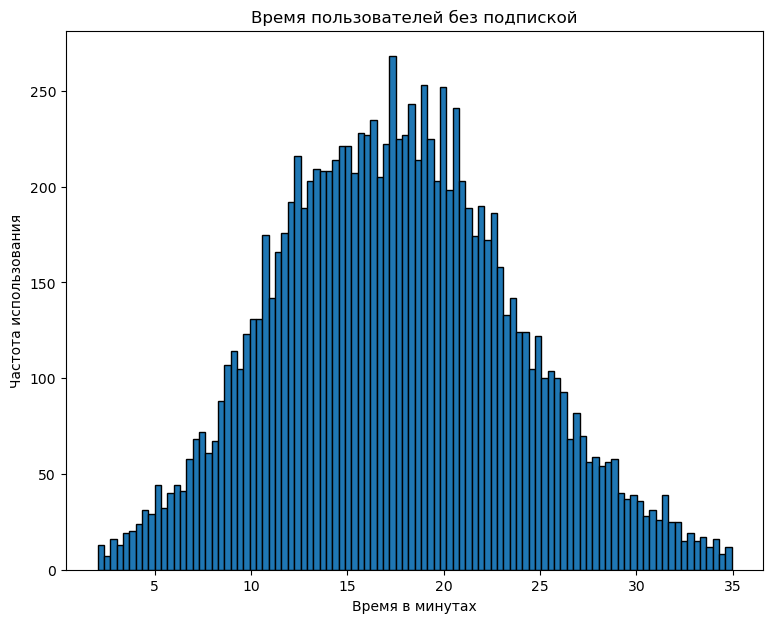

In [59]:
# График времени использования для пользователей без подписки
users_rides_subscriptions_free['duration'].sort_values().plot(y = 'duration', kind = 'hist', bins = 100, ec='black', figsize=(9, 7))

plt.title('Время пользователей без подпиской')
plt.xlabel('Время в минутах')
plt.ylabel('Частота использования')
plt.show()

- Из графиков следует что время использования у пользователей с подпиской составляет от 3 минут до 41 минуты, а у пользователей без подписки от 2 минут до 35 минут.  
- Оснавная масса пользователей с подпиской пользуются самокатами от 10 до 27 минут.  
Пользователи без подписки используют самокаты от 8 до 27 минут.

In [60]:
# Посмотрим общую информацию о расстоянии для пользователей с подпиской
users_rides_subscriptions_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

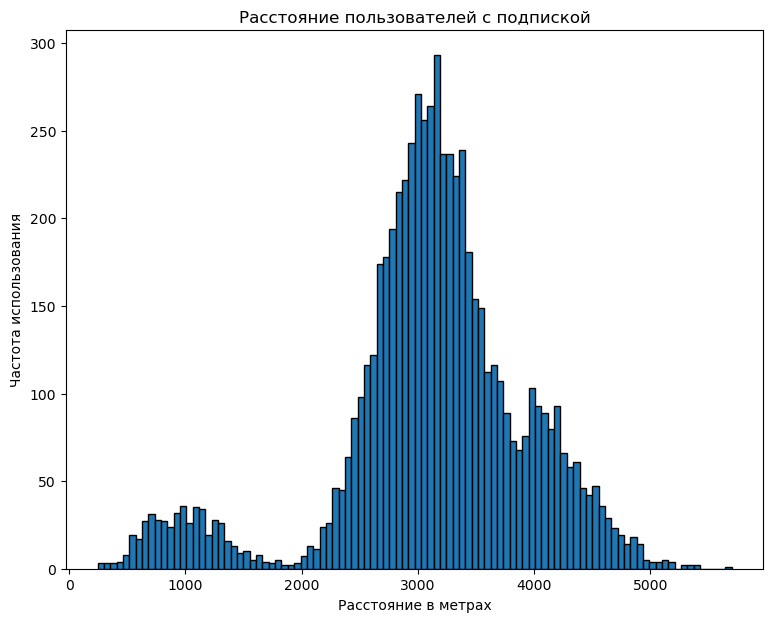

In [61]:
# Построим график о расстоянии для пользователей с подпиской
users_rides_subscriptions_ultra['distance'].sort_values().plot(y = 'distance', kind = 'hist', bins = 100, ec='black', figsize=(9, 7))

plt.title('Расстояние пользователей с подпиской')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Частота использования')
plt.show()

In [62]:
# Посмотрим общую информацию о расстоянии для пользователей без подписки
users_rides_subscriptions_free['distance'].describe()

count    11473.000000
mean      3028.374239
std       1235.541051
min          0.855683
25%       2360.878149
50%       3102.083025
75%       3883.979311
max       7066.003772
Name: distance, dtype: float64

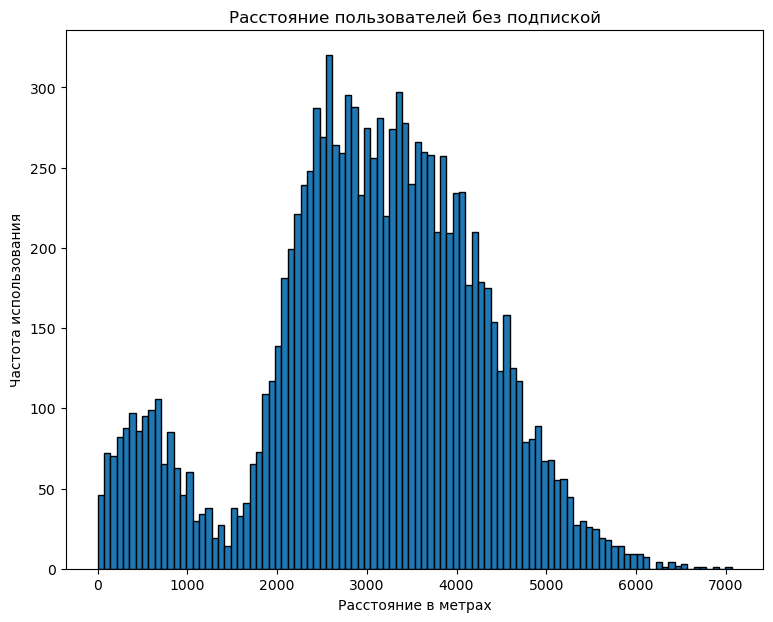

In [63]:
# График расстояния для пользователей без подписки
users_rides_subscriptions_free['distance'].sort_values().plot(y = 'distance', kind = 'hist', bins = 100, ec='black', figsize=(9, 7))

plt.title('Расстояние пользователей без подпиской')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Частота использования')
plt.show()

- Из графиков видно что пользователи с подпиской использовали самокаты для поездок на расстояния от 244 метров до 5700 метров, а пользователи без подписки на расстояние от 0,8 метра до 7070 метров.  
- Основная масса поездок совершённая пользователями с подпиской составляет от 2300 метров до 4300 метров.  
Пользователи без подписки совершали поездки чаще всего на расстояние от 1800 метров до 4800 метров.  
- У обеих групп есть ещё по одному ярко выраженному пику с поездками на расстояние от 244 метров до 1500 метров у пользователей с подпиской и от 0,8 метра до 1100 метров у пользователей без подписки.

- Пользователи с подпиской используют самокаты чаще всего для передвиженя на расстояние от 2300 м. до 4300 м. и затрачивают на это от 10 до 27 минут.  
- Пользователи без подписки используют самокаты чаще для поездок на расстояние от 1800 м. до 4800 м. и затрачивают на это от 8 до 27 минут.  
- Разброс расстояния у пользователей без подписки на 1000 метров больше чем у пользователей с подпиской но при этом затраченное время у обеих групп практически одинаково.

### Обработка малого пика

In [64]:
# Сделаем срез по малому пику
pic = users_rides_subscriptions.loc[users_rides_subscriptions['distance'] <= 1500]
pic

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199
20,2,Станислав,31,Омск,ultra,923.007439,6.914760,2021-08-03,8,6,0,199
47,4,Константин,26,Ростов-на-Дону,ultra,724.559572,11.811399,2021-11-14,11,6,0,199
91,9,Ян,21,Пятигорск,ultra,979.657684,17.521497,2021-03-08,3,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
17936,1532,Алексей,26,Тюмень,free,303.787850,7.792490,2021-05-21,5,8,50,0
17942,1532,Алексей,26,Тюмень,free,662.468186,9.528773,2021-11-18,11,8,50,0
17948,1533,Степан,22,Краснодар,free,310.488247,10.642389,2021-02-21,2,8,50,0
17954,1533,Степан,22,Краснодар,free,1034.998188,6.299996,2021-06-23,6,8,50,0


In [65]:
# Посмотрим колличество поездок по городам
pic['city'].value_counts().sort_values()

city
Москва            168
Омск              203
Тюмень            206
Пятигорск         220
Сочи              228
Екатеринбург      246
Краснодар         247
Ростов-на-Дону    278
Name: count, dtype: int64

- Пользователи совершали примерно одинаковое колличество поездок в разных городах.  
Возможно это связанно с тем что пункты проката расположенны в зонах отдыха например парках и пляжах.

## Шаг 5. **Подсчёт выручки**

Создать датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4:  
найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

### Переименовываем столбцы

In [66]:
# Округляем продолжительность каждой поездки в каждой строке 
# исходного датафрейма для подсчёта стоимости до следующего целого числа.
users_rides_subscriptions['duration'] = np.ceil(users_rides_subscriptions['duration'])

In [67]:
users_rides_subscriptions_sum = users_rides_subscriptions.groupby(['user_id', 'month']).agg({'distance':'sum', 'duration':['sum', 'count'], 'subscription_type':'first', 'minute_price':'first', 'start_ride_price':'first', 'subscription_fee':'first'})
# Переименование столбцов
users_rides_subscriptions_sum.columns = ['sum_distance', 'sum_duration', 'count_rides',
                         'subscription_type', 'minute_price',
                         'start_ride_price', 'subscription_fee']  
users_rides_subscriptions_sum

sum_distance  sum_duration  count_rides subscription_type  \
user_id month                                                              
1       1       7027.511294          42.0            2             ultra   
        4        754.159807           7.0            1             ultra   
        8       6723.470560          46.0            2             ultra   
        10      5809.911100          32.0            2             ultra   
        11      7003.499363          56.0            3             ultra   
...                     ...           ...          ...               ...   
1534    6       3409.468534          26.0            2              free   
        8       7622.453034          48.0            2              free   
        9       4928.173852          23.0            1              free   
        11     13350.015305          78.0            4              free   
        12      2371.711192          16.0            1              free   

               minute_price  start_ride_price  subscription_fee  
user_id month                                                    
1       1                 6                 0               199  
        4                 6                 0               199  
        8                 6                 0               199  
        10                6                 0               199  
        11                6                 0               199  
...                     ...               ...               ...  
1534    6                 8                50                 0  
        8                 8                50                 0  
        9                 8                50                 0  
        11                8                50                 0  
        12                8                50                 0  

[11300 rows x 7 columns]

In [68]:
# Проверим общие данные таблицы
users_rides_subscriptions_sum.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11300 entries, (1, 1) to (1534, 12)
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sum_distance       11300 non-null  float64
 1   sum_duration       11300 non-null  float64
 2   count_rides        11300 non-null  int64  
 3   subscription_type  11300 non-null  object 
 4   minute_price       11300 non-null  int64  
 5   start_ride_price   11300 non-null  int64  
 6   subscription_fee   11300 non-null  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 663.2+ KB


### Создаём столбец *month_sum*

In [69]:
# добавим столбец с помесячной выручкой, которую принёс каждый пользователь
users_rides_subscriptions_sum['month_sum'] = (users_rides_subscriptions_sum['start_ride_price'] * 
                                              users_rides_subscriptions_sum['count_rides']) + (users_rides_subscriptions_sum['minute_price'] * 
                                              users_rides_subscriptions_sum['sum_duration']) + users_rides_subscriptions_sum['subscription_fee']
users_rides_subscriptions_sum

sum_distance  sum_duration  count_rides subscription_type  \
user_id month                                                              
1       1       7027.511294          42.0            2             ultra   
        4        754.159807           7.0            1             ultra   
        8       6723.470560          46.0            2             ultra   
        10      5809.911100          32.0            2             ultra   
        11      7003.499363          56.0            3             ultra   
...                     ...           ...          ...               ...   
1534    6       3409.468534          26.0            2              free   
        8       7622.453034          48.0            2              free   
        9       4928.173852          23.0            1              free   
        11     13350.015305          78.0            4              free   
        12      2371.711192          16.0            1              free   

               minute_price  start_ride_price  subscription_fee  month_sum  
user_id month                                                               
1       1                 6                 0               199      451.0  
        4                 6                 0               199      241.0  
        8                 6                 0               199      475.0  
        10                6                 0               199      391.0  
        11                6                 0               199      535.0  
...                     ...               ...               ...        ...  
1534    6                 8                50                 0      308.0  
        8                 8                50                 0      484.0  
        9                 8                50                 0      234.0  
        11                8                50                 0      824.0  
        12                8                50                 0      178.0  

[11300 rows x 8 columns]

In [70]:
# Посмторим описательную часть для столбца month_sum
users_rides_subscriptions_sum['month_sum'].describe()

count    11300.000000
mean       342.754956
std        153.317314
min         74.000000
25%        234.000000
50%        319.000000
75%        415.000000
max       1444.000000
Name: month_sum, dtype: float64

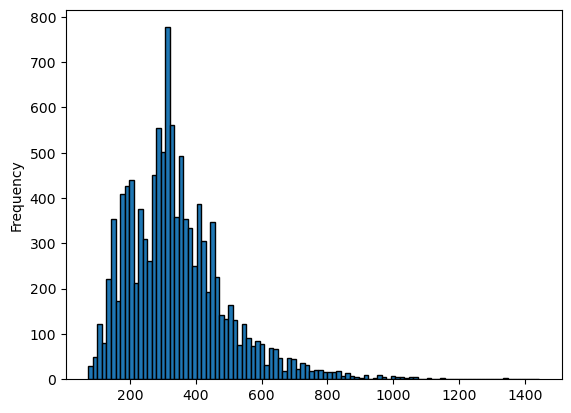

In [71]:
users_rides_subscriptions_sum['month_sum'].sort_values().plot(x = 'month_sum', kind = 'hist', bins = 100, ec='black')
plt.show()

**Вывод**  
Из графика видно что основная масса дохов с пользователей в месяц составляет от 100 до 600 рублей.  
Минимальный доход составляет 74 рублей в месяц, а максимальный 1444 рубля.

## Шаг 6. **Проверка гипотез**

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.
  
6.1 Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.
  
6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.
  
6.3. Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.  
  
6.4. Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

6.4 Я использовал бы *scipy.stats.ttest_rel* в качестве *alternative (greater)*.

### Тратят ли пользователи с подпиской больше времени на поездки?

**Нулевая гипотеза**: пользователи с подпиской тратят столько же времени на поездки сколько и пользователи без подписки.  
  
**Альтернативная гипотеза**: пользователи с подпиской тратят больше времени на поездки чем пользователи без подписки.

In [72]:
# создадим две выборки:
# с подпиской
ultra = users_rides_subscriptions_ultra['duration']
# без подписки
free = users_rides_subscriptions_free['duration']

# задаём уровень значимости
alpha = 0.05

# проводим ttest для двух выборок, используем одностороннюю гипотезу «больше»
results = st.ttest_ind(ultra, free, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 4.704468074453899e-28
Отвергаем нулевую гипотезу


In [73]:
# Посмотрим среднее значение для пользователей с подпиской
users_rides_subscriptions_ultra['duration'].mean()

18.54198516280583

In [74]:
# Без подписки
users_rides_subscriptions_free['duration'].mean()

17.530771268800226

**Вывод**  
Гипотеза о том что пользователи с подпиской тратят больше времени на поездки чем пользователи без подписки имеет все основания на существование, так как и среднее значение в таблицах показывает тот же результат 18,54 минут у пользователей с подпиской и 17,53 минут у пользователей без подписки.

### Проверим проезжают ли пользователи с подпиской за одну поездку более 3130 метров.

**Нулевая гипотеза**: пользователи с подпиской проезжают за одну поездку расстояние 3130 метров.  
  
**Альтернативная гипотеза**: пользователи с подпиской проезжают за одну поездку расстояние больше 3130 метров.

In [75]:
# Создаём выборку
ultra_distance = users_rides_subscriptions_ultra['distance']

# Расстояние в 3130 метров
dist = 3130

# задаём уровень значимости
alpha = 0.05

# проводим ttest, используем одностороннюю гипотезу «больше»
results = st.ttest_1samp(ultra_distance, dist, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.9195368847849785
Нет оснований отвергнуть нулевую гипотезу


In [76]:
# Посмотрим общее колличество поездок более или равное 3130 метров.
users_rides_subscriptions_ultra_distance = users_rides_subscriptions_ultra.loc[users_rides_subscriptions_ultra['distance'] >= 3130]
users_rides_subscriptions_ultra_distance['distance'].count()

3350

In [77]:
# посмотрим общее колличество поездок
users_rides_subscriptions_ultra['distance'].count()

6500

In [78]:
# Посмотрим среднюю дистанцию 
users_rides_subscriptions_ultra['distance'].mean()

3115.4453880370247

**Вывод**  
Нет оснований отвергать гипотезу о том что пользователи с подпиской проезжают за одну поездку 3130 метров.  
Среднее расстояние которое проезжают пользователи с подпиской составляет 3115,44 метра.  
Общее количество поездок пользователей с подпиской составляет 6500 строк, а поездок более или равных 3130 метров составляет 3350 строк. Это практически половина поездок совершонных пользователями с подпиской.

### Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

**Нулевая гипотеза**: помесячная выручка от пользователей с подпиской и пользователей без подписки одинакова.  
  
**Альтернативная гипотеза**: помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

In [79]:
# создадим две выборки:
# с подпиской
ultra = users_rides_subscriptions_sum.loc[users_rides_subscriptions_sum['subscription_type'] == 'ultra']
ultra_sum = ultra['month_sum']
# без подписки
free = users_rides_subscriptions_sum.loc[users_rides_subscriptions_sum['subscription_type'] == 'free']
free_sum = free['month_sum']

# задаём уровень значимости
alpha = 0.05

# проводим ttest для двух выборок, используем одностороннюю гипотезу «больше»
results = st.ttest_ind(ultra_sum, free_sum, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 2.0314113674863288e-30
Отвергаем нулевую гипотезу


In [80]:
# Посмотрим среднее значение для пользователей с подпиской
ultra_sum.mean()

362.7921906022502

In [81]:
# без подписки
free_sum.mean()

329.3326437121324

**Вывод**  
Нет оснований отвергать гипотезу о том что, по месячная выручка от пользователей с подпиской выше относительно выручки от пользователей без подписки. Средние показатели говорят о том же, 362 рублей у пользователей с подпиской и 329 рублей у пользователей без подписки.

## Шаг 7 **Общий вывод**

- Знакомство с данными  
Данные прадставленные в этом исследовании за период с 1 января 2021 года по 30 декабря 2021 года.  
Во время ознакомления с данными были выявленны: не соответствие типа данных, дубликаты, проверенны пропуски.   
Был изменён тип данных в датасете "Поездки" в столбце *data* с *object* на *datetime*.  
Обработанны дубликаты в датасете "Пользователи" (удалены).  
В датасете "Поездки" был создан столбец *month* (номер месяца) на основе столбца *date*.  

- Города  
Чаще всего пользователи пользуются самокатами компании "GoFast" в Пятигорске (219) и Екатеринбурге (206), соответсевенно меньше всего в Москве (168) и Тюмени (180). Как вариант, возможно это зависит от колличества пунктов проката в данных городах.   
  
- Пользователи  
Пользователей с бесплатной подпиской больше чем с платной (*free* - 835, *ultra* - 699). Возможно это связанно с частотой использования данного средства передвижения.   
Основная масса пользователей имеет возраст от 17 до 34 лет.  
Меньше всего сервисом пользуются пользователи в возрасте от 37, 43 лет.    
  
- Расстояние  
основная масса поездок совершена на расстояние от 2200 метров до 4700 метров, но унас есть ещё одно пиковое значение с расстоянием от 0,8 метра до 1500 метров.  
Время затраченное на эти поездки составляет от 2 минут до 20 минут.  
Пользователи использовали самокаты практически круглый год, возможно это связанно с определённым городом.    
Пользователи совершали примерно одинаковое колличество поездок в разных городах.  
Возможно это связанно с тем что пункты проката расположенны в зонах отдыха например парках и пляжах.  
  
- Время  
Был обнаружен аномальный выброс в 95 строк где продолжительность поездок составляла 0,5 минуты на расстояние более 4000 метров. Возможно это ошибка внесения данных или проведённая рекламная акция, у нас нет таких данных, были удалены.  
Основная продолжительность времени использования самокатов от 8 минут до 27 минут.  
  
- Объединение данных  
Были объеденены все три датасета и на основе этой сводной таблицы были созданны два датасета пользователи с подпиской и без.  
Пользователи с подпиской используют самокаты чаще всего для передвиженя на расстояние от 2300 м. до 4300 м. и затрачивают на это от 10 до 27 минут.
Пользователи без подписки используют самокаты чаще для поездок на расстояние от 1800 м. до 4800 м. и затрачивают на это от 8 до 27 минут.* для подсчёта платежей по месяцам.  
Разброс расстояния у пользователей без подписки на 1000 метров больше чем у пользователей с подпиской но при этом затраченное время у обеих групп практически одинаково.  
  
- Подсчёт выручки  
Перед подсчётом создаём таблицу ссуммируемыми данными по месяцам и переименовываем столбцы.  
Создаем столбец *month_sum* для подсчёта платежей по месяцам.  
Основная масса дохов с пользователей в месяц составляет от 100 до 600 рублей. Минимальный доход составляет 74 рублей в месяц, а максимальный 1444 рубля.  
  
- Проверка гипотез  
- Гипотеза 1  
Гипотеза о том что пользователи с подпиской тратят больше времени на поездки чем пользователи без подписки имеет все основания на существование, так как и среднее значение в таблицах показывает тот же результат 18,18 минут у пользователей с подпиской и 17,38 минут у пользователей без подписки.  
  
- Гипотеза 2  
Нет оснований отвергать гипотезу о том что пользователи с подпиской проезжают за одну поездку более чем 3130 метров. Общее количество поездок пользователей с подпиской составляет 6500 строк, а поездок более или равных 3130 метров составляет 3350 строк. Это практически половина поездок совершонных пользователями с подпиской.  
  
- Гипотеза 3  
Нет оснований отвергать гипотезу о том что, по месячная выручка от пользователей с подпиской выше относительно выручки от пользователей без подписки. Средние показатели говорят о том же, 337 рублей у пользователей с подпиской и 274 рубля у пользователей без подписки.

## Шаг 8. Распределения

### 

- Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.  

- Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

<BarContainer object of 100 artists>

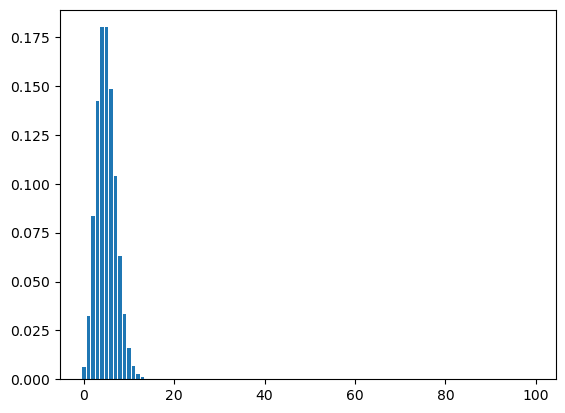

In [82]:
user = 99 # колличество подписчиков

minimum = 0.05 # план 5%

distr = [] # создаём список 

for k in range(0, user + 1):
     choose = factorial(user) / (factorial(k) * factorial(user - k)) # считаем кол-во вариантов выбрать k из user
     prob = choose * minimum**k * (1-minimum)**(user-k) # считаем вероятность
     distr.append(prob) # добавляем очередную вероятность prob в список distr
        
# построение гистограммы распределения вероятностей
plt.bar(range(0, user + 1), distr)

In [83]:
from scipy.stats import binom

target_clients = 100  # Целевое количество клиентов для продления подписки
p_renewal = 0.1       # Вероятность продления подписки

# Подбор значения параметра n
n = 1
while binom.cdf(target_clients - 1, n, p_renewal) > 0.05:
    n += 1

# Вывод 
print(f"Минимальное количество промокодов: {n}")
print(f"Вероятность не выполнить план при таком количестве промокодов: {binom.cdf(target_clients - 1, n, p_renewal):.3%}")

Минимальное количество промокодов: 1161
Вероятность не выполнить план при таком количестве промокодов: 4.976%


### 

- Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [84]:
maxi = 399500 # максимум пользователей открывших уведомление
n = 1000000 # задаём параметры 
p = 0.4 # биномиального распределения

mu = n * p # рассчитываем параметры 
sigma = sqrt(n * p * (1 - p)) # нормального распределения

lmbd = n * p

distr = st.norm(mu, sigma) # задаём нормальное распределение

result = distr.cdf(maxi) # находим вероятность
print(result)

0.15371708296369768


- 15% на то что уведомление откроют не более 399,5 тыс. пользователей.